In [79]:
!pip3 install psycopg2
!pip3 install flask
!pip3 install seaborn
!pip3 install descartes
!pip install sklearn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 7.1 MB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 6.7 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=2397 sha256=64762260e5a4d7a2c73f9745b6714197bb33d24b1b6bebc1e8f7fcf1f93bb429
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import helper
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import shapely
from shapely import wkt
import geopandas as gpd
import functools
import itertools
from scipy import interpolate
import numpy as np

### Abstract ###   
There are two major challenges in conducting a rigorous seismic fragility analysis over an entire region, which are addressed in this paper. 

1) How to model structural response for individual buildings using surrogate models based on long term instrumentation.  
2) How to scale this analysis to an entire region - instrumenting every structure in a region would be prohibitively costly, so we must develop a way to extrapolate from the subset of structures for which we have a surrogate model. 

Using Netherlands 3D bag dataset, we develop an unsupervised clustering algorithm which groups buildings with similar characteristics, age and geometries. If a surrogate model is available for one building in a cluster, then we can adopt this surrogate model for the entire cluster. Coupling the adopted surrogate model with a location specific ground motion model then enables the development of a full fragility curve. If no surrogate model is available for a cluster then we cannot develop fragility curves for any buildings in this cluster, and this suggests that futher instrumentation is required.

### Netherlands 3D bag database has been downloaded from http://3dbag.bk.tudelft.nl/downloads in gpkg format, and uploaded to a postGIS server hosted on AWS

In [3]:
def get_house_attributes():
    query = """SELECT 
               bouwjaar as year,
               ST_Area(ST_Force2D(geom)) as footprint_area,
               "roof_0.95" as height
               from bag3d"""
    return helper.execute_query(query)
def get_region_house_attributes(regioncode):
    query = """SELECT 
               bouwjaar as year,
               ST_Area(ST_Force2D(geom)) as footprint_area,
               "roof_0.95" as height
               from bag3d
               where gemeentecode='{}' """.format(regioncode)
    return helper.execute_query(query)
@helper.maybe
def year_from_datetime(datetime):
    return datetime.year
@helper.maybe
def filter_logical(year):
    return year if year<2021 else None
@helper.maybe
def volume(area, height):
    return area*height
def calculate_year_and_volume(res):
    return filter_logical(year_from_datetime(res[0])), volume(res[1],res[2])

### First explore simple data characteristics for Netherlands, and for Groningen in particular

In [4]:
years_and_volumes = [calculate_year_and_volume(i)
                     for i in get_house_attributes()]

In [5]:
groningen_years_and_volumes = [calculate_year_and_volume(i)
                     for i in get_region_house_attributes("0014")]

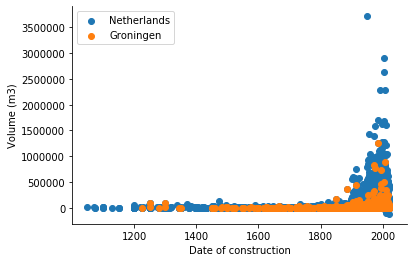

In [6]:
fig,ax = plt.subplots(1)
ax.scatter([i[0] for i in years_and_volumes],
           [i[1] for i in years_and_volumes], label='Netherlands')
ax.scatter([i[0] for i in groningen_years_and_volumes],
           [i[1] for i in groningen_years_and_volumes], label='Groningen')
ax.set_ylabel('Volume (m3)')
ax.set_xlabel('Date of construction')
ax.legend()
sns.despine()

### Data format
 ogc_fid                     | integer                  |  
 
 identificatie               | character varying(16)    |  
 
 aanduidingrecordinactief    | boolean                  |  
 
 aanduidingrecordcorrectie   | integer                  |  
 
 officieel                   | boolean                  |  
 
 inonderzoek                 | boolean                  |  
 
 documentnummer              | character varying(20)    | 
 
 documentdatum               | date                     | 
 
 bouwjaar                    | date                     | 
 
 begindatumtijdvakgeldigheid | timestamp with time zone |
 
 einddatumtijdvakgeldigheid  | timestamp with time zone | 
 
 gemeentecode                | character varying(4)     | 
 
 ground_0.00                 | real                     | 
 
 ground_0.10                 | real                     | 
 
 ground_0.20                 | real                     | 
 
 ground_0.30                 | real                     | 
 
 ground_0.40                 | real                     | 
 
 ground_0.50                 | real                     | 
 
 roof_0.25                   | real                     | 
 
 rmse_0.25                   | real                     | 
 
 roof_0.50                   | real                     | 
 
 rmse_0.50                   | real                     | 
 
 roof_0.75                   | real                     | 
 
 rmse_0.75                   | real                     | 
 
 roof_0.90                   | real                     | 
 
 rmse_0.90                   | real                     | 
 
 roof_0.95                   | real                     | 
 
 rmse_0.95                   | real                     | 
 
 roof_0.99                   | real                     | 
 
 rmse_0.99                   | real                     | 
 
 roof_flat                   | boolean                  | 
 
 nr_ground_pts               | integer                  | 
 
 nr_roof_pts                 | integer                  | 
 
 ahn_file_date               | timestamp with time zone | 
 
 ahn_version                 | smallint                 | 
 
 height_valid                | boolean                  | 
 
 tile_id                     | character varying        | 
 
 geom                        | geometry(PolygonZ,28992) |
 

### Example geometry

In [7]:
def get_some_shapes():
    q = """SELECT ST_AsText(ST_Force2d(ST_Transform(bag.geom,4326))) from bag3d bag
           WHERE bag.gemeentecode='0014';"""
    spatialq = """SELECT ST_AsText(ST_Force2d(ST_Transform(bag.geom,4326)))
                  from bag3d bag
                  LEFT JOIN netherlandsregions nr
                  on ST_Within(ST_Force2d(ST_Transform(bag.geom,4326)),
                               nr.wkb_geometry);"""
    return [i[0] for i in helper.execute_query(q)]
def convert_to_shapes(i):
    return wkt.loads(i)

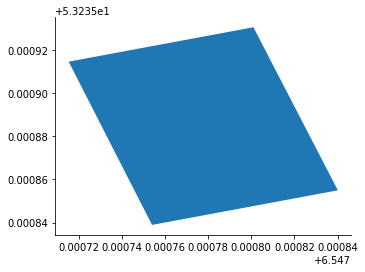

In [8]:
shapes = gpd.GeoDataFrame([convert_to_shapes(i) for i in get_some_shapes()],columns=['geometry'])
ax = shapes[0:1].plot()
sns.despine()

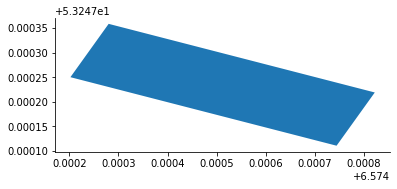

In [9]:
ax2 = shapes[1:2].plot()
sns.despine()

In [10]:
shapes.to_file("groningenbag.json", driver="GeoJSON")

### Two possible methods for clustering
#### Goal - we want a clustering algorithm which is translation and rotation invariant, but sensitive to scale
1) Use Hausdorff distance to create similarity matrix -see Joshi, D., Samal, A. K., & Soh, L. K. (2009, March). Density-based clustering of polygons. In 2009 IEEE symposium on computational intelligence and data mining (pp. 171-178). IEEE.  
2) Convert polygon to 1d representation using distance from centroid and then use time series clustering -see Yankov, D., & Keogh, E. (2006, December). Manifold clustering of shapes. In Sixth International Conference on Data Mining (ICDM'06) (pp. 1167-1171). IEEE.

### Investigate time series approach

In [11]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return 1000* c * r #in metres

def polygon_to_timeseries(polygon):
    centroidx,centroidy = polygon.centroid.xy
    centroid = list(zip(centroidx, centroidy))[0]
    pointsx, pointsy = polygon.exterior.coords.xy
    pointlist = list(zip(pointsx, pointsy))
    return [haversine(*point, *centroid) for point in pointlist ]

In [12]:
shapes['timeseries'] = shapes['geometry'].apply(polygon_to_timeseries)

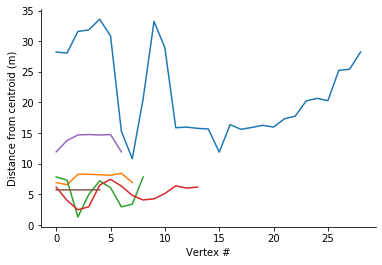

In [13]:
fig,ax = plt.subplots(1)
for idx,ts in enumerate(shapes.iloc[150:156]['timeseries']):
    ax.plot(ts, label=idx+150)
ax.set_ylabel('Distance from centroid (m)')
ax.set_xlabel('Vertex #')

sns.despine()

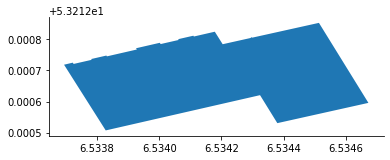

In [14]:
ax=shapes.iloc[150:151].plot()
sns.despine()

### Needs to be consistently re-meshed so every polygon has an equal number of points


In [15]:
def cumulativedistance_from_startvertex(polygon):
    pointsx, pointsy = polygon.exterior.coords.xy
    pointlist = list(zip(pointsx, pointsy))
    consecutive_pairs = list(zip(pointlist,pointlist[1:]))
    consecutive_distances = [0]+[haversine(*thisvertex,*nextvertex)
                            for thisvertex,nextvertex in consecutive_pairs]
    cumulative_distances = itertools.accumulate(consecutive_distances)
    return cumulative_distances
def distancesensitive_polygon_to_timeseries(polygon):
    fromcentroids = polygon_to_timeseries(polygon)
    linear_from_start = cumulativedistance_from_startvertex(polygon)
    return list(zip(linear_from_start,fromcentroids))

In [16]:
shapes['perimeter_timeseries'] = shapes['geometry'].apply(distancesensitive_polygon_to_timeseries)

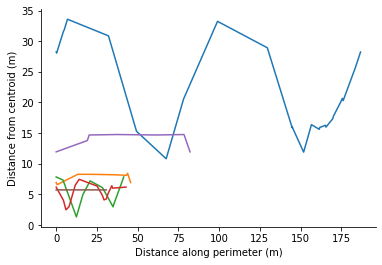

In [17]:
fig,ax = plt.subplots(1)
for idx,ts in enumerate(shapes.iloc[150:156]['perimeter_timeseries']):
    ax.plot([i[0] for i in ts],[i[1] for i in ts], label=idx+150)
ax.set_ylabel('Distance from centroid (m)')
ax.set_xlabel('Distance along perimeter (m)')
sns.despine()

### Now interpolate to standardize lengths. Scale information will still be embedded in distance from centroid metric

In [18]:
def interpolater(xycoords, numpoints=100):
    x = [i[0] for i in xycoords]
    y = [i[1] for i in xycoords]
    f = interpolate.interp1d(x, y)
    newx = np.linspace(0, max(x),numpoints)
    return list(zip(newx, f(newx)))

In [19]:
shapes['discretized_perimeter_timeseries'] = shapes['perimeter_timeseries'].apply(interpolater)

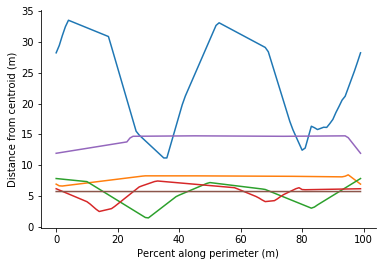

In [20]:
fig,ax = plt.subplots(1)
for idx,ts in enumerate(shapes.iloc[150:156]['discretized_perimeter_timeseries']):
    ax.plot([i[1] for i in ts], label=idx+150)
ax.set_ylabel('Distance from centroid (m)')
ax.set_xlabel('Percent along perimeter (m)')
sns.despine()

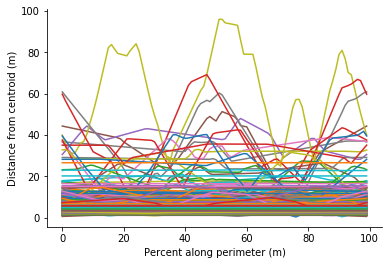

In [21]:
fig,ax = plt.subplots(1)
for idx,ts in enumerate(shapes['discretized_perimeter_timeseries'][0::100]):
    ax.plot([i[1] for i in ts], label=idx)
ax.set_ylabel('Distance from centroid (m)')
ax.set_xlabel('Percent along perimeter (m)')
sns.despine()

### Yankov & Keogh perform clustering on these perimeter-centroid time series using a two-step algorithm  
- first perform dimensionality reduction using isomap (manifold learning)
- then use k-means on reduce dimensionality dataset

In [34]:
from sklearn.manifold import Isomap
X = np.array(list(shapes['discretized_perimeter_timeseries'].apply(lambda x:[i[1] for i in x])))
embedding = Isomap(n_components=2,n_neighbors=250)
X_transformed = embedding.fit_transform(X[::20,:])

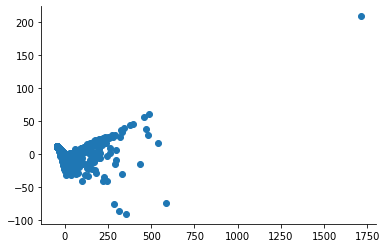

In [35]:
fig,ax = plt.subplots(1)
ax.scatter(X_transformed[:,0],X_transformed[:,1])
sns.despine()

(-50, 50)

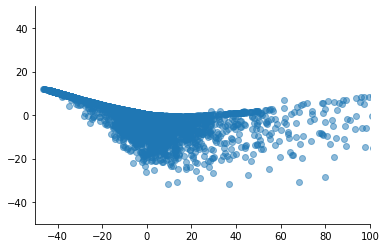

In [36]:
fig,ax = plt.subplots(1)
ax.scatter(X_transformed[:,0],X_transformed[:,1], alpha=0.5)
sns.despine()
ax.set_xlim([-50,100])
ax.set_ylim([-50,50])

### Simple linear PCA

In [39]:
from sklearn.decomposition import PCA
embedding = PCA(n_components=2)
X_PC = embedding.fit_transform(X[::20,:])

(-50, 50)

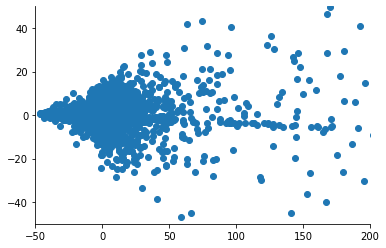

In [43]:
fig,ax = plt.subplots(1)
ax.scatter(X_PC[:,0],X_PC[:,1])
sns.despine()
ax.set_xlim([-50,200])
ax.set_ylim([-50,50])